<a href="https://colab.research.google.com/github/brandonnassir/Predictive_Policing_Model/blob/main/predictive_policing_dimensionality_reduction_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
#Change the current working directory to the path of Google Cloud Drive
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)
#Use the wget command to download the dataset to this path
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/data.csv
file_path = '/content/drive/MyDrive/Crime_Data_from_2020_to_Present_new.csv'


Mounted at /content/drive/
--2024-05-08 18:28:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/data.csv
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-05-08 18:28:19 ERROR 403: Forbidden.



In [ ]:
# Import the neccessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.animation as animation
from IPython.display import Image
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, precision_score

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.shape

(932140, 28)

In [ ]:
# Data Cleaning

lon_min, lon_max = -118.68, -118.15 # Removes crimes that occured outside of city bounds
lat_min, lat_max = 33.69, 34.35
df = df[(df['LON'] >= lon_min) & (df['LON'] <= lon_max) & (df['LAT'] >= lat_min) & (df['LAT'] <= lat_max)] # Remove rows where longitude and latitude are outside the specified bounds

df = df[~((df['LAT'] == 0) & (df['LON'] == 0))] # Now df will contain only the rows where either latitude or longitude is not 0.
df = df.drop_duplicates(subset='DR_NO', keep='first') # Now df will contain only the rows where each value in the first column is unique.
df = df.dropna(subset=['DATE OCC', 'LAT', 'LON']) # Now 'df' will contain only the rows where 'DATE OCC', 'LAT', and 'LON' do not have NaN values.
df.shape
# Find duplicated rows based on the first column
#duplicates = df[df.duplicated(subset='DR_NO', keep=False)]
#duplicates = duplicates.sort_values(by='DR_NO')

(929876, 28)

In [ ]:
df.shape

(929876, 28)

In [ ]:
# Number of Crimes Committed by Day of the Week
df['DATE OCC'] = pd.to_datetime(df['DATE OCC']) # Convert 'DATE OCC' to datetime
df['Day of Week'] = df['DATE OCC'].dt.day_name()# Extract the day of the week and add it as a new column # The day_name() function returns the name of the day in a week (e.g., Monday, Tuesday)
df['Month'] = df['DATE OCC'].dt.month_name()
df['Day of Month'] = df['DATE OCC'].dt.day # Extract Day of the Month
monthly_crime_count = df['Month'].value_counts().sort_index()
df['Months'] = df['DATE OCC'].dt.month
day_to_num = { 'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}
df['Days of Week'] = df['Day of Week'].map(day_to_num)# Apply the mapping to the 'Day of the Week' column
#Number of Crimes Committed by Hour of Day
crime_count = df['Day of Week'].value_counts() # Count the number of crimes for each day of the week
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] # Sort the days in the order you prefer (optional, for better visualization)
crime_count = crime_count.reindex(ordered_days)
# Number of Crimes Committed by Day
df['Hour of Day'] = df['TIME OCC'] // 100
hourly_crime_count = df['Hour of Day'].value_counts().sort_index() # Count the number of crimes for each hour
crime_count_by_date = df['DATE OCC'].value_counts().sort_index()
# Number of Crimes Occurred per Year
df['Year'] = df['DATE OCC'].dt.year # Extract the year and create a new column for it
# Filter the DataFrame
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
cutoff_date = pd.Timestamp('2023-12-31')
df = df[(df['Date Rptd'] < cutoff_date) & (df['DATE OCC'] < cutoff_date)] # Remove dates after 1/1/24
# Group by year and count the number of crimes
crime_count_by_year = df.groupby('Year').size()
crime_count_by_area = df['AREA NAME'].value_counts()
#df.to_csv('updated_dataframe.csv', index=False)


<ipython-input-7-96fc86ebaef6>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC']) # Convert 'DATE OCC' to datetime
<ipython-input-7-96fc86ebaef6>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])


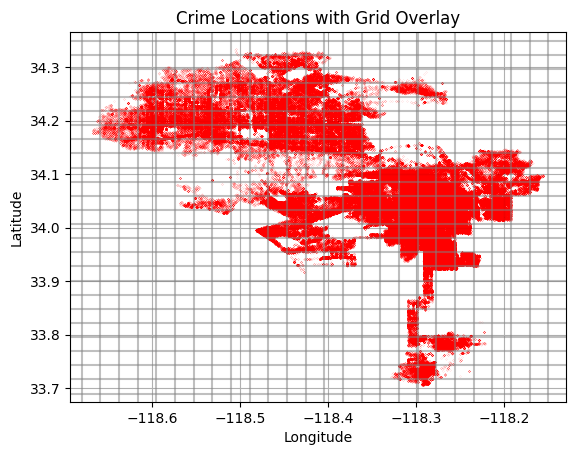

In [ ]:
plt.plot(df["LON"],df["LAT"],'r.',markersize=0.1)

num_lat_cells = 25  # Change these based on your grid size
num_lon_cells = 25

# Define the size of each grid cell
lat_step = (lat_max - lat_min) / num_lat_cells  # num_lat_cells is the number of cells in latitude
lon_step = (lon_max - lon_min) / num_lon_cells  # num_lon_cells is the number of cells in longitude

# Creating the grid lines
lat_lines = np.linspace(lat_min, lat_max, num_lat_cells+1)
lon_lines = np.linspace(lon_min, lon_max, num_lon_cells+1)

# Drawing the grid lines
for lat in lat_lines:
    plt.axhline(y=lat, color='grey', linestyle='-', alpha=0.5)
for lon in lon_lines:
    plt.axvline(x=lon, color='grey', linestyle='-', alpha=0.5)

plt.title('Crime Locations with Grid Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


# Function to assign each crime to a grid cell
def assign_to_grid(lat, lon):
    lat_index = int((lat - lat_min) / lat_step)
    lon_index = int((lon - lon_min) / lon_step)
    return lat_index, lon_index

In [ ]:
# Apply the function to your DataFrame
df['Grid_Cell'] = df.apply(lambda row: assign_to_grid(row['LAT'], row['LON']), axis=1)

# Group by 'Grid_Cell' and count crimes in each cell
crime_counts = df.groupby('Grid_Cell').size()

# Filter out grid cells with no crimes
crime_cells = crime_counts[crime_counts > 0].index.tolist()

# Keep only rows with crimes in the relevant grid cells
df = df[df['Grid_Cell'].isin(crime_cells)]

In [ ]:
# Sort the grid cells by their spatial order
sorted_cells = sorted(crime_cells, key=lambda x: (x[0], x[1]))  # Sort by latitude index, then longitude index

# Create a mapping from grid cell to enumeration
cell_to_enum = {cell: i for i, cell in enumerate(sorted_cells)}

# Apply enumeration to DataFrame
df['Grid_Cell_Enum'] = df['Grid_Cell'].map(cell_to_enum)

In [ ]:
# Assuming df is your DataFrame
# Ensure 'DATE OCC' and 'Hour of Day' are already defined as described earlier

# Convert 'Grid_Cell_Enum' to one-hot encoding
encoder = OneHotEncoder(sparse=False)
grid_cell_one_hot = encoder.fit_transform(df[['Grid_Cell_Enum']])
# Convert the one-hot encoding to a DataFrame
grid_cell_one_hot_df = pd.DataFrame(grid_cell_one_hot, columns=[f'cell_{i}' for i in range(grid_cell_one_hot.shape[1])])
# Concatenate with the original DataFrame
df2 = pd.concat([df['DATE OCC'], df['Hour of Day'], df['Months'], df['Days of Week'], grid_cell_one_hot_df], axis=1)
# Group by 'DATE OCC', 'Hour of Day', 'Months', and 'Days of Week', and sum the one-hot encoded vectors
grouped = df2.groupby(['DATE OCC', 'Hour of Day', 'Months', 'Days of Week']).sum()
grouped_non_binarized = grouped.copy()  # Create a copy for non-binarized data

# The resulting 'grouped' DataFrame contains the aggregated one-hot vectors for each hour of each day
# List of one-hot encoded columns
one_hot_columns = [col for col in grouped.columns if col.startswith('cell_')]

# Convert values > 0 to 1 in one-hot encoded columns for binarized DataFrame
for col in one_hot_columns:
    grouped[col] = grouped[col].apply(lambda x: 1 if x > 0 else 0)

# Now, all your one-hot encoded columns in 'grouped' have values as either 0 or 1

# Reset index to make 'DATE OCC', 'Hour of Day', 'Months', 'Days of Week' into columns again
grouped.reset_index(inplace=True)
grouped_non_binarized.reset_index(inplace=True)

# Optionally, if you need to drop columns or do further processing, you can continue from here.
# For example, dropping 'DATE OCC' if not needed in further analysis:
# grouped = grouped.drop(columns=['DATE OCC'])
# grouped_non_binarized = grouped_non_binarized.drop(columns=['DATE OCC'])


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-11-819193d03360>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped.reset_index(inplace=True)
<ipython-input-11-819193d03360>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped.reset_index(inplace=True)
<ipython-input-11-819193d03360>:

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
data_x = grouped_non_binarized.filter(like='cell_').values
data_y = grouped.filter(like='cell_').values

In [ ]:
print(data_x.shape)
print(data_y.shape)

(35040, 282)
(35040, 282)


In [ ]:
input_dim = data_x.shape[1]  # number of 'cell_' columns
encoding_dim = 60  # This is the size of our encoded representations (can be changed)

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder
autoencoder = Model(input_layer, decoded)

In [ ]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_layer, decoded)


In [ ]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_layer, decoded)

In [ ]:
autoencoder.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False), loss='binary_crossentropy')
autoencoder.fit(data_x, data_y, epochs=1200, batch_size=64, shuffle=True)


Epoch 1/1200
548/548 [==============================] - 3s 3ms/step - loss: 0.0079
Epoch 2/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0075
Epoch 3/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 4/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 5/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0074
Epoch 6/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 7/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 8/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
Epoch 9/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0075
Epoch 10/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0074
Epoch 11/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0074
Epoch 12/1200
548/548 [==============================] - 2s 3ms/step - loss: 0.0076
E

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False), loss='binary_crossentropy')
model.fit(data_x, data_y, epochs=1200, batch_size=128, shuffle=True)

Epoch 1/1200
274/274 [==============================] - 2s 3ms/step - loss: 3.1278e-04
Epoch 2/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.8478e-04
Epoch 3/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.7389e-04
Epoch 4/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.6637e-04
Epoch 5/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.6083e-04
Epoch 6/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.5654e-04
Epoch 7/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.5307e-04
Epoch 8/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.5009e-04
Epoch 9/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.4857e-04
Epoch 10/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.4551e-04
Epoch 11/1200
274/274 [==============================] - 1s 3ms/step - loss: 2.4325e-04
Epoch 12/1200
274/274 [==================

In [ ]:
# Encoder model
encoder = Model(input_layer, encoded)

# Decoder model
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-4](encoded_input)
decoder_layer2 = autoencoder.layers[-3](decoder_layer1)  # 3rd last layer
decoder_layer3 = autoencoder.layers[-2](decoder_layer2) # 2nd last layer
decoder_output = autoencoder.layers[-1](decoder_layer3)

decoder = Model(encoded_input, decoder_output)
# # Example for a single data point
# encoded_data = encoder.predict(data[0].reshape(1, -1))
# decoded_data = decoder.predict(encoded_data)
# predicted_directions = (decoded_data > 0.5).astype(int)

ValueError: Exception encountered when calling layer "dense_8" (type Dense).

Dimensions must be equal, but are 60 and 64 for '{{node dense_8/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](Placeholder, dense_8/MatMul/ReadVariableOp)' with input shapes: [?,60], [64,128].

Call arguments received by layer "dense_8" (type Dense):
  • inputs=tf.Tensor(shape=(None, 60), dtype=float32)

In [ ]:
# Assuming 'data' is your original training data and 'autoencoder' is your trained model

# Decode all training data
decoded_data = model.predict(data_x)

# Apply threshold to convert probabilities to binary values (0 or 1)
decoded_data_binary = np.where(decoded_data > 0.5, 1, 0)

# Count correct predictions
correct_predictions = np.sum(decoded_data_binary == data_y)

print(f"Number of correct element-wise predictions: {correct_predictions}")
print(f"Number of total elements: {int(data_x.shape[0]*int(data_x.shape[1]))}")

1095/1095 [==============================] - 1s 1ms/step
Number of correct element-wise predictions: 9881280
Number of total elements: 9881280
